In [ ]:
using Pkg
Pkg.activate(@__DIR__)

# # If you've already run the comman below, all you need to do is execute
Pkg.instantiate()

# # The first time you use this notebook, you'll have to run
# Pkg.develop(PackageSpec(url=joinpath(@__DIR__, "..")))

`MISPExamples` defines a "general" version of the Tikhonov & Samarskii example (with all parameters free to choose) as well as a "default" version with pre-set parameters.

In most cases, the values of the parameters before and after applying the Kirchoff (integral) transformation are available, and the names of the functions available in `MISPExamples` should match that in e.g. Abdulla & Poggi (2019)

In [2]:
using MISPExamples
const TSE = MISPExamples.TikhonovSamarskiiDefault

@static if VERSION < v"0.7-"
    using Compat: stdout, range
end

┌ Info: Recompiling stale cache file /Users/jgoldfar/.julia/compiled/v0.7/MISPExamples/chfNJ.ji for MISPExamples [c1e558f6-6b4a-11e8-0037-fbb02674179a]
└ @ Base loading.jl:1185


If you'd like to examine the problem data, it is available as `t1` in that module.
For the most part, we don't need to work with these parameters ourselves; the main thing this is used for is to hold the solution of the rootfinding method needed to calculate `alpha`:

In [3]:
print(TSE.t1) # Verbose output by default

ProblemData(c1=-1.0, c2=1.0, k1=1.0, k2=1.0, gamma=1.0, alpha=0.7555195764068221)

We should be able to plot the corresponding data using our preferred plotting package.

In [4]:
using PyPlot

The length of the space domain is "free" since the example in Tikhonov & Samarskii is a solution in the half-space, but we fix a right-boundary location to be a multiple of the final location of the "true" boundary to avoid degenerate phases appearing in our solution.

In [5]:
lBdy = TSE.spaceLength
xGrid = range(0, stop=lBdy, length=100)
tGrid = TSE.tGrid(100)

0.0:0.010101010101010102:1.0

The transformed initial data is available as `Phi`; evidently the data is continuous, but note the lack of differentiability at the level `Phi=0`: this is the initial interface location

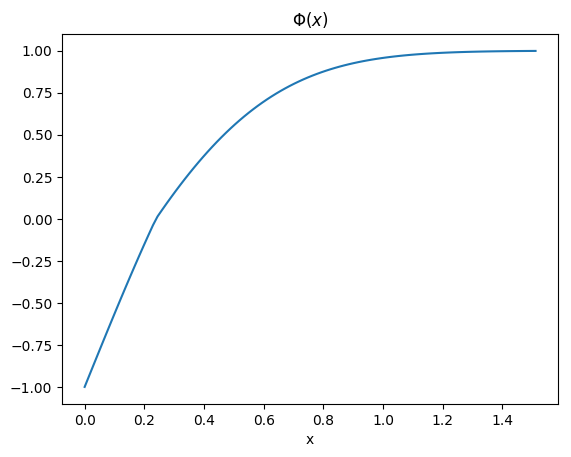

In [6]:
withfig(figure()) do
    plot(xGrid, map(TSE.Phi, xGrid))
    title(L"\Phi(x)")
    xlabel("x")
end

In [ ]:
outputDir = joinpath(pwd(), "figures")
mkpath(outputDir)

The function `v(x,t)` is the analytic (true) transformed state vector

In [ ]:
withfig(figure()) do
    surf(xGrid, tGrid, [TSE.v(x,t) for x in xGrid, t in tGrid])
    title(L"v(x,t)")
    xlabel("t")
    ylabel("x")
    # # Uncomment the line below to save this plot to `outputDir`
    # savefig(joinpath(outputDir, "TikhonovSamarskiiSolveV.png"))
end

We could also plot the solution as a series of slices for more convenient inclusion into e.g. a report.

In [ ]:
withfig(figure()) do
    plot(xGrid, map(TSE.Phi, xGrid))
    for t in TSE.tGrid(4)
        plot(xGrid, map(x->TSE.v(x,t), xGrid))
    end
    legend(append!(["\\Phi"], ["t=$t" for t in TSE.tGrid(4)]))
    title(L"v(x,t)")
    xlabel("x")
    # # Uncomment the line below to save this plot to `outputDir`
    # savefig(joinpath(outputDir, "TikhonovSamarskiiSolveVSlice.png"))
end

The functions `p` and `g` represent the heat flux on the right- and left-hand sides of the fixed domain, respectively.

In [ ]:
withfig(figure()) do
    plot(tGrid, map(TSE.p, tGrid))
    title(L"p(t)")
    xlabel("t")
    legend(L"p(t) = k_2 u_x(\ell, t)", loc=8, fontsize="x-small")
    # # Uncomment the line below to save this plot to `outputDir`
    # savefig(joinpath(outputDir, "TikhonovSamarskiiSolveP.png"))
end

In [ ]:
withfig(figure()) do
    plot(tGrid, map(TSE.g, tGrid))
    title(L"g(t)")
    xlabel("t")
    legend("g(t) = k_1 u_x(0, t)", loc=8, fontsize="x-small")
    # # Uncomment the line below to save this plot to `outputDir`
    # savefig(joinpath(outputDir, "TikhonovSamarskiiSolveG.png"))
end

`nu(t)` is the Dirichlet data on the right-hand side of the domain

In [ ]:
withfig(figure()) do
    plot(tGrid, map(TSE.nu, tGrid))
    legend("nu(t) = u(\ell, t)", loc=8, fontsize="x-small")
end

`Gamma` is the transformed Dirichlet data on the right-hand side of the domain.

In [ ]:
withfig(figure()) do
    plot(tGrid, map(TSE.Gamma, tGrid))
    title(L"\Gamma(t)")
    xlabel("t")
    legend(L"\Gamma(t) = F(u(\ell, t))", loc=8, fontsize="x-small")
    # # Uncomment the line below to save this plot to `outputDir`
    # savefig(joinpath(outputDir, "TikhonovSamarskiiSolveGamma.png"))
end

Having `b(v)` and the function `v(x,t)`, we can show the composition, which should have a jump along the boundary curve:

In [ ]:
withfig(figure()) do
    surf(xGrid, tGrid, [TSE.b(TSE.v(x,t)) for x in xGrid, t in tGrid])
    title(L"b(v(x,t))")
    xlabel("t")
    ylabel("x")
end

Having the analytic data, could (if we were so inclined) calculate the "optimal" error possible from a finite difference scheme; this in particular would serve as a check against any algebra issues.

In [ ]:
using LinearAlgebra
NVals = 8:10:1000
L2ErrorVals = zeros(length(NVals))
for (Ni, N) in enumerate(NVals)

    lBdy = TSE.spaceLength
    xGrid = range(0, stop=lBdy, length=N)
    tGrid = TSE.tGrid(N)

    vapprox = [TSE.v(x,t) for x in xGrid, t in tGrid]
    @static if VERSION >= v"0.7-"
        btapprox = diff([TSE.b(vapprox[i, j]) for i in eachindex(xGrid), j in eachindex(tGrid)], dims=2) / step(tGrid)
        vxxapprox = diff(diff(vapprox, dims=1), dims=1)/(step(xGrid)^2)
    else
        btapprox = diff([TSE.b(vapprox[i, j]) for i in eachindex(xGrid), j in eachindex(tGrid)], 2) / step(tGrid)
        vxxapprox = diff(diff(vapprox, 1), 1)/(step(xGrid)^2)
    end
    L2ErrorVals[Ni] = vecnorm(btapprox[1:(end-2), :] - vxxapprox[:, 1:(end-1)])*step(xGrid)*step(tGrid)
end

In [ ]:
withfig(figure()) do
    plot(NVals, L2ErrorVals)
    title("Optimal Error in Finite Difference Scheme")
    xlabel(L"N_x \equiv N_t")
    ylabel(L"\Vert b(v)_\bar{t} - v_{\bar{x}x}\Vert_{\ell_2, h, \tau}")
    # # Uncomment the line below to save this plot to `outputDir`
    # savefig(joinpath(outputDir, "TikhonovSamarskiiSolveApproxError.png"))
end

This example shows the spatial distribution of such a finite difference approximation; we can see that the errors all appear near the interface curve, as one might expect.

In [ ]:
N = 64

lBdy = TSE.spaceLength
xGrid = range(0, stop=lBdy, length=N)
tGrid = TSE.tGrid(N)
vapprox = [TSE.v(x,t) for x in xGrid, t in tGrid]
@static if VERSION >= v"0.7-"
    btapprox = diff([TSE.b(vapprox[i, j]) for i in eachindex(xGrid), j in eachindex(tGrid)], dims=2) / step(tGrid)
    vxxapprox = diff(diff(vapprox, dims=1), dims=1)/(step(xGrid)^2)
else
    btapprox = diff([TSE.b(vapprox[i, j]) for i in eachindex(xGrid), j in eachindex(tGrid)], 2) / step(tGrid)
    vxxapprox = diff(diff(vapprox, 1), 1)/(step(xGrid)^2)
end
fapprox = btapprox[1:(end-2), :] - vxxapprox[:, 1:(end-1)]
withfig(figure()) do
    surf(tGrid[1:(end-1)], xGrid[1:(end-2)], fapprox)
    title(L"b(v)_\bar{t} - v_{\bar{x}x} \equiv f(x,t) \approx 0")
    xlabel("t")
    ylabel("x")
end